In [1]:
# ---------------------------------------------------------
# Diabetes Meal Plan Evaluation Notebook
# Author: Kshitiz Sikriwal
# ---------------------------------------------------------

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

pd.set_option("display.float_format", lambda x: f"{x:.2f}")
plt.rcParams["figure.figsize"] = (12,5)
plt.rcParams["axes.grid"] = True

# Dataset path
DATA_PATH = Path("/Users/kshitizsikriwal/Kshitiz/evaluation/Gemini/meal_to_yoga_top1_contrastive_Diabetes.xlsx")

if not DATA_PATH.exists():
    raise FileNotFoundError(f"❌ File not found: {DATA_PATH.resolve()}")

df = pd.read_excel(DATA_PATH, sheet_name=None)
sheet_name = list(df.keys())[0]
df = df[sheet_name]

print(f"✅ Loaded: {DATA_PATH.name} | Sheet: {sheet_name} | Shape: {df.shape}")
display(df.head(3))



✅ Loaded: meal_to_yoga_top1_contrastive_Diabetes.xlsx | Sheet: Sheet1 | Shape: (42, 24)


,meal_index,meal_plan,meal_day,meal_time,meal_name,meal_description,Calories (kcal),Total_Fat (g),Protein (g),Carbohydrates (g),...,Selenium (µg),Magnesium (mg),yoga_index,yoga_plan,yoga_day,yoga_time,yoga_detailed,yoga_exercise,yoga_precautions,similarity
0,0,Plan A,Monday,Morning,Steel-Cut Oats,"Oats with flaxseeds, walnuts, and blueberries.",500,20,15,70,...,10,100,84,Plan B,Monday,Morning,Vajrasana (Thunderbolt Pose) for 5 minutes. Fo...,30 minutes of outdoor brisk walking (5.5-6.5 k...,Check blood glucose before and after. Kapalbha...,0.28
1,1,Plan A,Monday,Afternoon,Quinoa & Black Bean Salad,"Quinoa, black beans, corn, bell peppers, avoca...",700,25,25,100,...,15,150,37,Plan A,Saturday,Afternoon,Vajrasana (Thunderbolt Pose) for 5-10 minutes....,20 minutes of light walking (3 km/h) or gentle...,This is an active recovery session. If walking...,0.26
2,2,Plan A,Monday,Evening,Grilled Salmon,Grilled salmon with roasted broccoli and a sma...,800,30,50,75,...,30,80,103,Plan B,Sunday,Afternoon,"Halasana (Plough Pose), 2 supported reps held ...",20 minutes of resistance band work (full body ...,This combination of yoga and resistance work t...,0.21


In [2]:
# ---------------------------------------------------------
# Normalize column names & detect plan/day columns
# ---------------------------------------------------------
def canon(txt):
    if pd.isna(txt): return txt
    return "_".join(str(txt).strip().lower().split())

df.columns = [canon(c) for c in df.columns]

plan_col = next((c for c in df.columns if "plan" in c), None)
day_col  = next((c for c in df.columns if "day" in c), None)
if not plan_col or not day_col:
    raise ValueError(f"❌ Could not auto-detect plan/day columns. Columns found: {df.columns.tolist()}")

df[plan_col] = df[plan_col].astype(str).apply(canon)
df[day_col]  = df[day_col].astype(str).apply(canon)

print(f"🧩 Plan column: {plan_col} | Day column: {day_col}")
print("Detected plans:", df[plan_col].unique())
print("Detected days:", df[day_col].unique())



🧩 Plan column: meal_plan | Day column: meal_day
Detected plans: ['plan_a' 'plan_b']
Detected days: ['monday' 'tuesday' 'wednesday' 'thursday' 'friday' 'saturday' 'sunday']


In [3]:
# ---------------------------------------------------------
# Robust nutrient mapping (10 nutrients from guidelines)
# ---------------------------------------------------------
nutrient_patterns = {
    "Calories (kcal)"       : ["calorie","energy","kcal"],
    "Total Fat (g)"         : ["total_fat","fat"],
    "Protein (g)"           : ["protein"],
    "Carbohydrates (g)"     : ["carbohydrate","carbs"],
    "Dietary Fiber (g)"     : ["fiber","fibre"],
    "Added Sugar (g)"       : ["sugar"],
    "Omega-3 (ALA) (g)"     : ["omega","ala"],
    "EPA + DHA (mg)"        : ["epa","dha"],
    "Selenium (µg)"         : ["selenium","se"],
    "Magnesium (mg)"        : ["magnesium","mg"]
}

matched = {}
for friendly, pats in nutrient_patterns.items():
    for p in pats:
        hit = next((col for col in df.columns if p in col), None)
        if hit:
            matched[friendly] = hit
            break

print("🧮 Nutrient Mapping:")
for k,v in matched.items():
    print(f"  {k:25s} → {v}")

found_cols = list(matched.values())
if not found_cols:
    raise ValueError("❌ No nutrient columns found!")

for c in found_cols:
    df[c] = pd.to_numeric(df[c], errors="coerce")



🧮 Nutrient Mapping:
  Calories (kcal)           → calories_(kcal)
  Total Fat (g)             → total_fat_(g)
  Protein (g)               → protein_(g)
  Carbohydrates (g)         → carbohydrates_(g)
  Dietary Fiber (g)         → dietary_fiber_(g)
  Added Sugar (g)           → added_sugar_(g)
  Omega-3 (ALA) (g)         → omega-3_(ala,_g)
  EPA + DHA (mg)            → epa_+_dha_(mg)
  Selenium (µg)             → selenium_(µg)
  Magnesium (mg)            → magnesium_(mg)


In [4]:
# ---------------------------------------------------------
# Aggregate daily totals → compute weekly averages
# ---------------------------------------------------------
daily_totals = (
    df.groupby([plan_col, day_col], as_index=False)[found_cols]
      .sum().sort_values([plan_col, day_col])
)
weekly_avg = daily_totals.groupby(plan_col)[found_cols].mean()

dataset_to_friendly = {v:k for k,v in matched.items()}

def make_series(plan_name):
    if plan_name not in weekly_avg.index:
        return pd.Series(dtype=float)
    return weekly_avg.loc[plan_name].rename(index=dataset_to_friendly)

weekly_avg_main = make_series("plan_a")
weekly_avg_alt  = make_series("plan_b")

print("✅ Weekly Averages Computed")
display(weekly_avg_main.round(2))
display(weekly_avg_alt.round(2))



✅ Weekly Averages Computed


Calories (kcal)     2014.29
Total Fat (g)         68.71
Protein (g)          105.71
Carbohydrates (g)    230.00
Dietary Fiber (g)     34.29
Added Sugar (g)       13.57
Omega-3 (ALA) (g)      1.46
EPA + DHA (mg)       244.29
Selenium (µg)         52.86
Magnesium (mg)       362.86
Name: plan_a, dtype: float64

Calories (kcal)     1964.29
Total Fat (g)         65.57
Protein (g)          107.86
Carbohydrates (g)    222.14
Dietary Fiber (g)     33.71
Added Sugar (g)       11.86
Omega-3 (ALA) (g)      1.34
EPA + DHA (mg)       322.86
Selenium (µg)         55.00
Magnesium (mg)       371.43
Name: plan_b, dtype: float64

In [5]:
# ---------------------------------------------------------
# Real-World Diabetes Nutrition Reference Midpoints
# ---------------------------------------------------------
guideline_mid = pd.Series({
    "Calories (kcal)"       : (1800 + 2200) / 2,   # 2000
    "Total Fat (g)"         : (44 + 78) / 2,       # 61
    "Protein (g)"           : (50 + 120) / 2,      # 85
    "Carbohydrates (g)"     : (180 + 275) / 2,     # 227.5
    "Dietary Fiber (g)"     : (25 + 40) / 2,       # 32.5
    "Added Sugar (g)"       : (0 + 25) / 2,        # 12.5
    "Omega-3 (ALA) (g)"     : (1.1 + 1.6) / 2,     # 1.35
    "EPA + DHA (mg)"        : (250 + 500) / 2,     # 375
    "Selenium (µg)"         : 55,
    "Magnesium (mg)"        : (310 + 420) / 2      # 365
})

guideline_mid = guideline_mid.reindex(weekly_avg_main.index)
print("📘 Diabetes Guideline Midpoints")
display(guideline_mid.round(2))



📘 Diabetes Guideline Midpoints


Calories (kcal)     2000.00
Total Fat (g)         61.00
Protein (g)           85.00
Carbohydrates (g)    227.50
Dietary Fiber (g)     32.50
Added Sugar (g)       12.50
Omega-3 (ALA) (g)      1.35
EPA + DHA (mg)       375.00
Selenium (µg)         55.00
Magnesium (mg)       365.00
dtype: float64

In [6]:
# ---------------------------------------------------------
# Compute MAE, MSE, RMSE per plan
# ---------------------------------------------------------
def compute_errors(pred, real):
    df_err = pd.DataFrame({"Predicted": pred, "Guideline": real})
    df_err["Absolute Error"] = (df_err["Predicted"] - df_err["Guideline"]).abs()
    df_err["Percentage Error (%)"] = (df_err["Absolute Error"] / df_err["Guideline"]) * 100
    mae = df_err["Absolute Error"].mean()
    mse = (df_err["Absolute Error"] ** 2).mean()
    rmse = np.sqrt(mse)
    metrics = pd.Series({"MAE": mae, "MSE": mse, "RMSE": rmse}).round(3)
    return df_err.round(2), metrics

main_errors, main_metrics = compute_errors(weekly_avg_main, guideline_mid)
alt_errors,  alt_metrics  = compute_errors(weekly_avg_alt,  guideline_mid)

print("📈 Diabetes — Plan A (Main) Errors")
display(main_errors)
display(main_metrics)

print("\n📈 Diabetes — Plan B (Alternate) Errors")
display(alt_errors)
display(alt_metrics)


📈 Diabetes — Plan A (Main) Errors


,Predicted,Guideline,Absolute Error,Percentage Error (%)
Calories (kcal),2014.29,2000.00,14.29,0.71
Total Fat (g),68.71,61.00,7.71,12.65
Protein (g),105.71,85.00,20.71,24.37
Carbohydrates (g),230.00,227.50,2.50,1.10
Dietary Fiber (g),34.29,32.50,1.79,5.49
Added Sugar (g),13.57,12.50,1.07,8.57
Omega-3 (ALA) (g),1.46,1.35,0.11,7.94
EPA + DHA (mg),244.29,375.00,130.71,34.86
Selenium (µg),52.86,55.00,2.14,3.90
Magnesium (mg),362.86,365.00,2.14,0.59


MAE      18.32
MSE    1779.87
RMSE     42.19
dtype: float64


📈 Diabetes — Plan B (Alternate) Errors


,Predicted,Guideline,Absolute Error,Percentage Error (%)
Calories (kcal),1964.29,2000.00,35.71,1.79
Total Fat (g),65.57,61.00,4.57,7.49
Protein (g),107.86,85.00,22.86,26.89
Carbohydrates (g),222.14,227.50,5.36,2.35
Dietary Fiber (g),33.71,32.50,1.21,3.74
Added Sugar (g),11.86,12.50,0.64,5.14
Omega-3 (ALA) (g),1.34,1.35,0.01,0.53
EPA + DHA (mg),322.86,375.00,52.14,13.90
Selenium (µg),55.00,55.00,0.00,0.00
Magnesium (mg),371.43,365.00,6.43,1.76


MAE     12.89
MSE    460.96
RMSE    21.47
dtype: float64

,Guideline (Midpoint),Predicted (Plan A),Predicted (Plan B),Z-Score (Plan A),Z-Score (Plan B)
Calories (kcal),2000.00,2014.29,1964.29,0.03,-0.06
Total Fat (g),61.00,68.71,65.57,0.01,0.01
Protein (g),85.00,105.71,107.86,0.04,0.04
Carbohydrates (g),227.50,230.00,222.14,0.00,-0.01
Dietary Fiber (g),32.50,34.29,33.71,0.00,0.00
Added Sugar (g),12.50,13.57,11.86,0.00,-0.00
Omega-3 (ALA) (g),1.35,1.46,1.34,0.00,-0.00
EPA + DHA (mg),375.00,244.29,322.86,-0.23,-0.09
Selenium (µg),55.00,52.86,55.00,-0.00,0.00
Magnesium (mg),365.00,362.86,371.43,-0.00,0.01


🔹 Avg |Z| (Plan A) = 0.032
🔹 Avg |Z| (Plan B) = 0.022


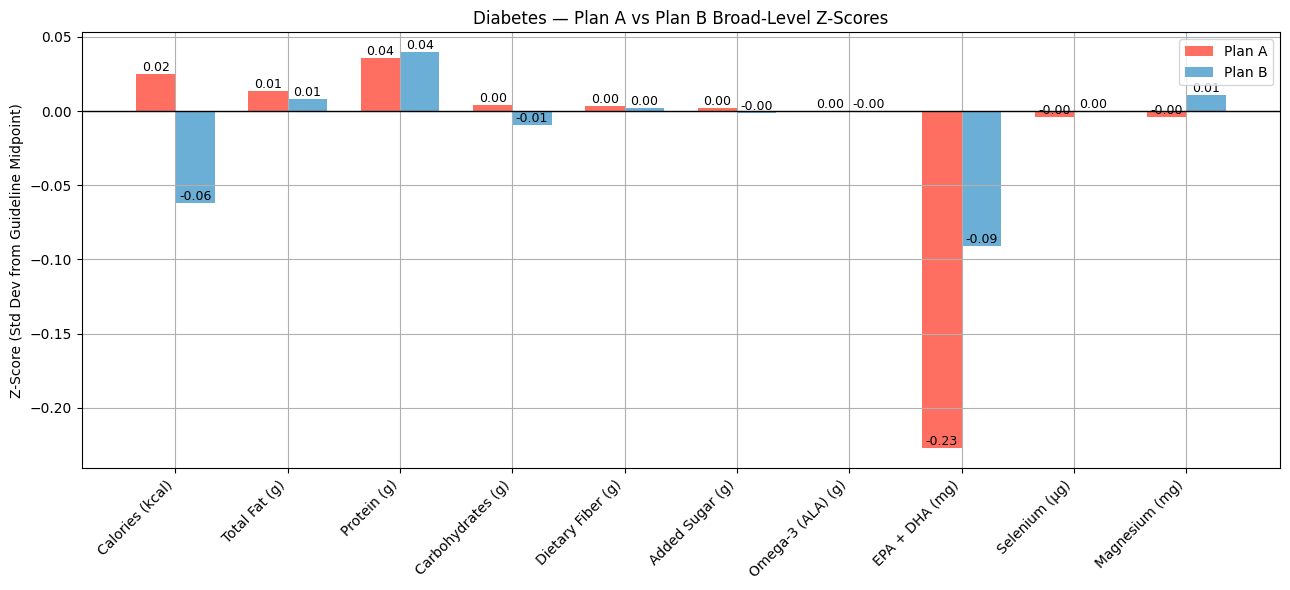

In [7]:
# ---------------------------------------------------------
# Broad-level Z-Score calculation (Plan A & Plan B)
# ---------------------------------------------------------
guideline_std = np.std(guideline_mid.values, ddof=0)

z_main = (weekly_avg_main.values - guideline_mid.values) / guideline_std
z_alt  = (weekly_avg_alt.values  - guideline_mid.values) / guideline_std

z_main_series = pd.Series(z_main, index=guideline_mid.index, name="Z-Score (Plan A)")
z_alt_series  = pd.Series(z_alt,  index=guideline_mid.index, name="Z-Score (Plan B)")

z_df = pd.DataFrame({
    "Guideline (Midpoint)" : guideline_mid,
    "Predicted (Plan A)"   : weekly_avg_main,
    "Predicted (Plan B)"   : weekly_avg_alt,
    "Z-Score (Plan A)"     : z_main_series,
    "Z-Score (Plan B)"     : z_alt_series
}).round(3)

display(z_df)

avg_abs_z_main = np.abs(z_main_series).mean()
avg_abs_z_alt  = np.abs(z_alt_series).mean()
print(f"🔹 Avg |Z| (Plan A) = {avg_abs_z_main:.3f}")
print(f"🔹 Avg |Z| (Plan B) = {avg_abs_z_alt:.3f}")

# Plot Z-scores
x = np.arange(len(z_df.index))
bar_width = 0.35
fig, ax = plt.subplots(figsize=(13,6))
bars1 = ax.bar(x - bar_width/2, z_main_series, width=bar_width, label="Plan A", color="#FF6F61")
bars2 = ax.bar(x + bar_width/2, z_alt_series,  width=bar_width, label="Plan B", color="#6BAED6")

for bars in [bars1, bars2]:
    for b in bars:
        h = b.get_height()
        ax.text(b.get_x() + b.get_width()/2, h, f"{h:.2f}", ha='center', va='bottom', fontsize=9)

ax.axhline(0, color='black', linewidth=1)
ax.set_xticks(x)
ax.set_xticklabels(z_df.index, rotation=45, ha='right')
ax.set_ylabel("Z-Score (Std Dev from Guideline Midpoint)")
ax.set_title("Diabetes — Plan A vs Plan B Broad-Level Z-Scores")
ax.legend()
plt.tight_layout()
plt.show()
